In [2]:
var openDigger = require('../src/open_digger');
var year = 2022, startYear = 2015;
var years = Array.from({ length: year - startYear + 1 }, (_, i) => i + startYear); // [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
var my_repo_id = 1129010;

# blueimp/jQuery-File-Upload 项目分析

## 1 每月新增 Star 和 Frok 的个数

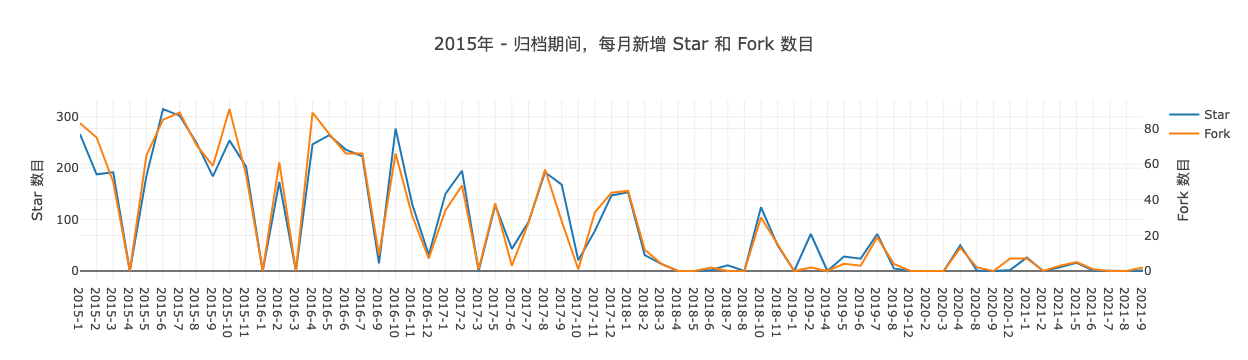

┌─────────┬───────────┬──────────────┬──────────────┐
│ (index) │   时间    │ 新增 Star 数 │ 新增 Fork 数 │
├─────────┼───────────┼──────────────┼──────────────┤
│    0    │ '2015-1'  │     266      │      83      │
│    1    │ '2015-2'  │     188      │      75      │
│    2    │ '2015-3'  │     192      │      50      │
│    3    │ '2015-4'  │      0       │      0       │
│    4    │ '2015-5'  │     185      │      65      │
│    5    │ '2015-6'  │     315      │      85      │
│    6    │ '2015-7'  │     302      │      89      │
│    7    │ '2015-8'  │     250      │      71      │
│    8    │ '2015-9'  │     184      │      59      │
│    9    │ '2015-10' │     254      │      91      │
│   10    │ '2015-11' │     203      │      54      │
│   11    │ '2016-1'  │      0       │      0       │
│   12    │ '2016-2'  │     173      │      61      │
│   13    │ '2016-3'  │      0       │      0       │
│   14    │ '2016-4'  │     246      │      89      │
│   15    │ '2016-5'  │     264     

In [3]:
Promise.all(years.map(y => {
    var q = `
    select t1.time as time1, t2.time as time2, stars, forks
    from 
    (select max(repo_stargazers_count)-min(repo_stargazers_count) as stars ,
    concat(toString(toYear(created_date)),'-',toString(toMonth(created_date))) as time
    from github_log.year${y} 
    where repo_id=${my_repo_id} and type in ('PullRequestEvent', 'PullRequestReviewCommentEvent')
    group by toYear(created_date),toMonth(created_date)
    order by toYear(created_date),toMonth(created_date)) t1
    
    FULL OUTER JOIN
    
    (select max(repo_forks_count)-min(repo_forks_count) as forks ,
    concat(toString(toYear(created_date)),'-',toString(toMonth(created_date))) as time
    from github_log.year${y} 
    where repo_id=${my_repo_id} and type in ('PullRequestEvent', 'PullRequestReviewCommentEvent')
    group by toYear(created_date),toMonth(created_date)
    order by toYear(created_date),toMonth(created_date)) t2
    
    ON t1.time=t2.time
    `
    return openDigger.driver.clickhouse.query(q);
})).then(data => {
    var stars = [], forks=[], time = [], tt = [];
    data.forEach(d => {
        d.forEach(dd => {
            stars.push(parseInt(dd.stars));
            forks.push(parseInt(dd.forks));
            if (dd.time1!='') {
                time.push(dd.time1);
                tt.push({'时间':dd.time1, '新增 Star 数':parseInt(dd.stars), '新增 Fork 数':parseInt(dd.forks)});
            }
            else {
                time.push(dd.time2);
                tt.push({'时间':dd.time2, '新增 Star 数':parseInt(dd.stars), '新增 Fork 数':parseInt(dd.forks)});
            }
        });
    });
    // openDigger.render.plotly(
    //     [{x: time, y: stars, type:'bar', name:'Star'}, {x: time, y: forks, type:'bar', name:'Fork'}], {
    //     title: '2015年 - 归档期间，每月新增 Star 和 Fork 数目',
    //     xaxis: {type: 'category'}
    // });
    openDigger.render.plotly([
        {x: time, y: stars, mode:'scatter', name:'Star'}, 
        {x: time, y: forks, mode:'scatter', name:'Fork',yaxis: 'y2'}
    ], {
        title: '2015年 - 归档期间，每月新增 Star 和 Fork 数目',
        yaxis: { title: 'Star 数目'},
        yaxis2: { overlaying: 'y', side: 'right', anchor: 'x', title: 'Fork 数目'},
        xaxis: {type: 'category'}
    });
    console.table(tt);
});

## 2 每月打开 Issue 和关闭 Issue 的个数

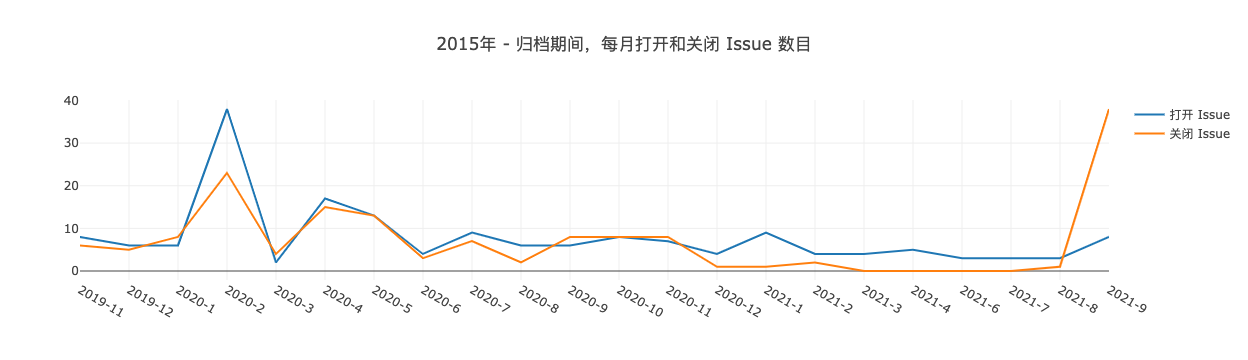

┌─────────┬───────────┬─────────────────┬─────────────────┐
│ (index) │   时间    │ 打开 Issue 数目 │ 关闭 Issue 数目 │
├─────────┼───────────┼─────────────────┼─────────────────┤
│    0    │ '2019-11' │        8        │        6        │
│    1    │ '2019-12' │        6        │        5        │
│    2    │ '2020-1'  │        6        │        8        │
│    3    │ '2020-2'  │       38        │       23        │
│    4    │ '2020-3'  │        2        │        4        │
│    5    │ '2020-4'  │       17        │       15        │
│    6    │ '2020-5'  │       13        │       13        │
│    7    │ '2020-6'  │        4        │        3        │
│    8    │ '2020-7'  │        9        │        7        │
│    9    │ '2020-8'  │        6        │        2        │
│   10    │ '2020-9'  │        6        │        8        │
│   11    │ '2020-10' │        8        │        8        │
│   12    │ '2020-11' │        7        │        8        │
│   13    │ '2020-12' │        4        │        1

In [4]:
Promise.all(years.map(y => {
    var q = `
    select t1.time as time1, t2.time as time2, open_issues_number, close_issues_number
    from 
    (select count(issue_id) as open_issues_number,
    concat(toString(toYear(created_date)),'-',toString(toMonth(created_date))) as time
    from github_log.year${y} 
    where repo_id=${my_repo_id} and type = 'IssuesEvent' and action in('opened','reopened')
    group by toYear(created_date),toMonth(created_date)
    order by toYear(created_date),toMonth(created_date)) t1
    
    FULL OUTER JOIN
    
    (select count(issue_id) as close_issues_number,
    concat(toString(toYear(created_date)),'-',toString(toMonth(created_date))) as time
    from github_log.year${y} 
    where repo_id=${my_repo_id} and type = 'IssuesEvent' and action in('closed')
    group by toYear(created_date),toMonth(created_date)
    order by toYear(created_date),toMonth(created_date)) t2
    
    ON t1.time=t2.time
    `
    return openDigger.driver.clickhouse.query(q);
})).then(data => {
    // console.log(data)
    var open_issues_number = [], close_issues_number=[], time = [], tt = [];
    data.forEach(d => {
        d.forEach(dd => {
            open_issues_number.push(parseInt(dd.open_issues_number));
            close_issues_number.push(parseInt(dd.close_issues_number));
            if (dd.time1!='') {
                time.push(dd.time1);
                tt.push({'时间':dd.time1, '打开 Issue 数目':parseInt(dd.open_issues_number), '关闭 Issue 数目':parseInt(dd.close_issues_number)});
            }
            else {
                time.push(dd.time2);
                tt.push({'时间':dd.time2, '打开 Issue 数目':parseInt(dd.open_issues_number), '关闭 Issue 数目':parseInt(dd.close_issues_number)});
            }
        });
    });
    // openDigger.render.plotly(
    //     [{x: time, y: stars, type:'bar', name:'打开 Issue'}, {x: time, y: forks, type:'bar', name:'关闭 Issue'}], {
    //     title: '2015年 - 归档期间，每月打开和关闭 Issue 数目',
    //     xaxis: {type: 'category'}
    // });
    openDigger.render.plotly([
        {x: time, y: open_issues_number, mode:'scatter', name:'打开 Issue'}, 
        {x: time, y: close_issues_number, mode:'scatter', name:'关闭 Issue'}
    ], {
        title: '2015年 - 归档期间，每月打开和关闭 Issue 数目',
        xaxis: {type: 'category'}
    });
    console.table(tt);
});

## 3 每月打开 PR 和合入 PR 的个数

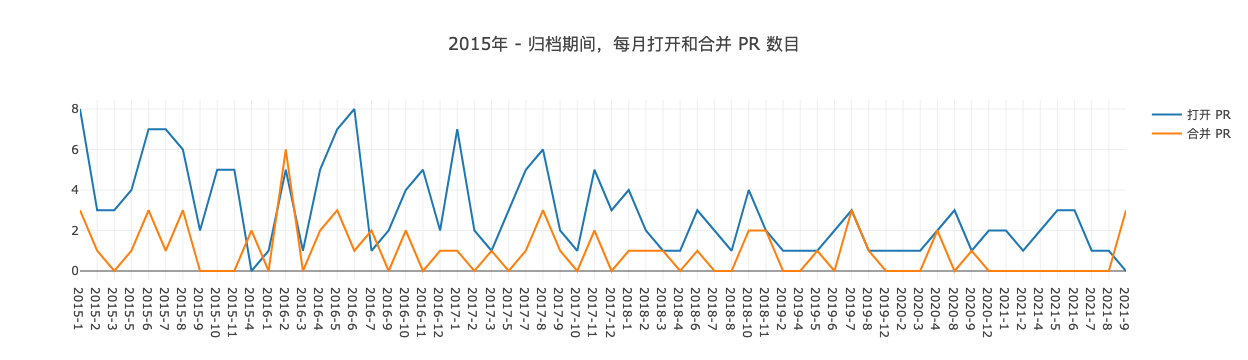

┌─────────┬───────────┬──────────────┬──────────────┐
│ (index) │   时间    │ 打开 PR 数目 │ 合并 PR 数目 │
├─────────┼───────────┼──────────────┼──────────────┤
│    0    │ '2015-1'  │      8       │      3       │
│    1    │ '2015-2'  │      3       │      1       │
│    2    │ '2015-3'  │      3       │      0       │
│    3    │ '2015-5'  │      4       │      1       │
│    4    │ '2015-6'  │      7       │      3       │
│    5    │ '2015-7'  │      7       │      1       │
│    6    │ '2015-8'  │      6       │      3       │
│    7    │ '2015-9'  │      2       │      0       │
│    8    │ '2015-10' │      5       │      0       │
│    9    │ '2015-11' │      5       │      0       │
│   10    │ '2015-4'  │      0       │      2       │
│   11    │ '2016-1'  │      1       │      0       │
│   12    │ '2016-2'  │      5       │      6       │
│   13    │ '2016-3'  │      1       │      0       │
│   14    │ '2016-4'  │      5       │      2       │
│   15    │ '2016-5'  │      7       │

In [5]:
Promise.all(years.map(y => {
    var q = `
    select t1.time as time1, t2.time as time2, open_PR_number, merge_PR_number
    from 
    (select count(issue_id) as open_PR_number,
    concat(toString(toYear(created_date)),'-',toString(toMonth(created_date))) as time
    from github_log.year${y} 
    where repo_id=${my_repo_id} and type = 'PullRequestEvent' and action in('opened','reopened')
    group by toYear(created_date),toMonth(created_date)
    order by toYear(created_date),toMonth(created_date)) t1
    
    FULL OUTER JOIN
    
    (select count(issue_id) as merge_PR_number,
    concat(toString(toYear(created_date)),'-',toString(toMonth(created_date))) as time
    from github_log.year${y} 
    where repo_id=${my_repo_id} and type = 'PullRequestEvent' and action in('closed') and pull_merged=1
    group by toYear(created_date),toMonth(created_date)
    order by toYear(created_date),toMonth(created_date)) t2
    
    ON t1.time=t2.time
    `
    return openDigger.driver.clickhouse.query(q);
})).then(data => {
    // console.log(data)
    var open_PR_number = [], merge_PR_number=[], time = [], tt = [];
    data.forEach(d => {
        d.forEach(dd => {
            // console.log(dd.time1,typeof(dd.time1));
            // console.log(dd.time2,typeof(dd.time2));
            open_PR_number.push(parseInt(dd.open_PR_number));
            merge_PR_number.push(parseInt(dd.merge_PR_number));
            if (dd.time1!='') {
                time.push(dd.time1);
                tt.push({'时间':dd.time1, '打开 PR 数目':parseInt(dd.open_PR_number), '合并 PR 数目':parseInt(dd.merge_PR_number)});
            }
            else {
                time.push(dd.time2);
                tt.push({'时间':dd.time2, '打开 PR 数目':parseInt(dd.open_PR_number), '合并 PR 数目':parseInt(dd.merge_PR_number)});
            }
            
        });
    });
    // openDigger.render.plotly(
    //     [{x: time, y: stars, type:'bar', name:'打开 PR'}, {x: time, y: forks, type:'bar', name:'合并 PR'}], {
    //     title: '2015年 - 归档期间，每月打开和合并 PR 数目',
    //     xaxis: {type: 'category'}
    // });
    openDigger.render.plotly([
        {x: time, y: open_PR_number, mode:'scatter', name:'打开 PR'}, 
        {x: time, y: merge_PR_number, mode:'scatter', name:'合并 PR'}
    ], {
        title: '2015年 - 归档期间，每月打开和合并 PR 数目',
        xaxis: {type: 'category'}
    });
    console.table(tt);
});

## 4 每月在仓库中活跃（只要有日志产生就算）的不同开发者总数

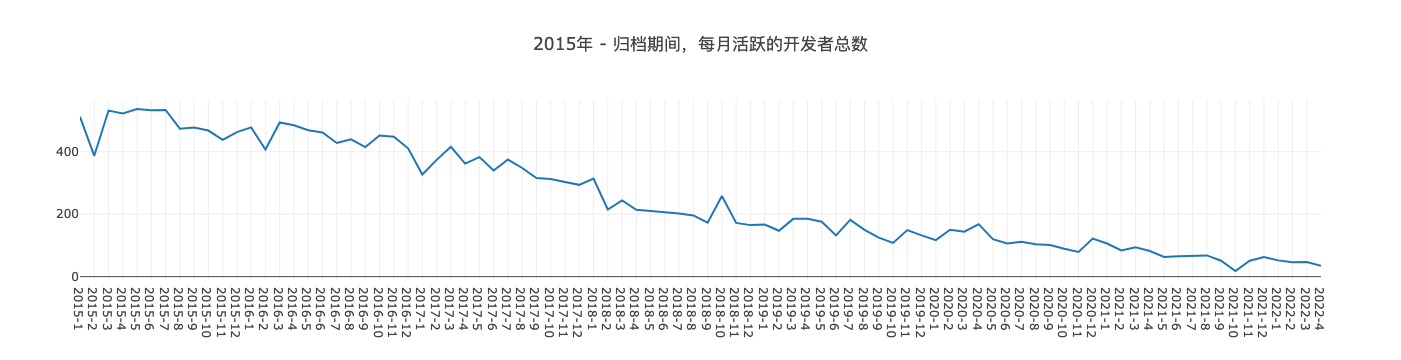

┌─────────┬───────────┬──────────────────┐
│ (index) │   时间    │ 活跃的开发者总数 │
├─────────┼───────────┼──────────────────┤
│    0    │ '2015-1'  │       512        │
│    1    │ '2015-2'  │       387        │
│    2    │ '2015-3'  │       532        │
│    3    │ '2015-4'  │       523        │
│    4    │ '2015-5'  │       537        │
│    5    │ '2015-6'  │       533        │
│    6    │ '2015-7'  │       534        │
│    7    │ '2015-8'  │       474        │
│    8    │ '2015-9'  │       478        │
│    9    │ '2015-10' │       468        │
│   10    │ '2015-11' │       438        │
│   11    │ '2015-12' │       463        │
│   12    │ '2016-1'  │       478        │
│   13    │ '2016-2'  │       407        │
│   14    │ '2016-3'  │       494        │
│   15    │ '2016-4'  │       485        │
│   16    │ '2016-5'  │       469        │
│   17    │ '2016-6'  │       462        │
│   18    │ '2016-7'  │       428        │
│   19    │ '2016-8'  │       440        │
│   20    │ '2016-9' 

In [7]:
Promise.all(years.map(y => {
    var q = `select count(distinct actor_id) as active_user_number,
    concat(toString(toYear(created_date)),'-',toString(toMonth(created_date))) as time
    from github_log.year${y} 
    where repo_id=${my_repo_id}
    group by toYear(created_date),toMonth(created_date)
    order by toYear(created_date),toMonth(created_date)
    `
    return openDigger.driver.clickhouse.query(q);
})).then(data => {
    var active_user_number = [], time = [], tt = [];
    data.forEach(d => {
        d.forEach(dd => {
            active_user_number.push(parseInt(dd.active_user_number));
            time.push(dd.time);
            tt.push({'时间':dd.time,'活跃的开发者总数':parseInt(dd.active_user_number)});
        });
    });
    openDigger.render.plotly(
        [{x: time, y: active_user_number, mode:"sactter"}], {
        title: '2015年 - 归档期间，每月活跃的开发者总数',
        xaxis: {type: 'category'}
    });
    console.table(tt);
});

## 5 Issue 从打开到关闭的平均时长和中位数（单位：天）

In [70]:
var query = openDigger.driver.clickhouse.query;
query(
    ` 
    select avg(dateDiff('day',issue_created_at,issue_closed_at)) as avg_time,median(dateDiff('day',issue_created_at,issue_closed_at)) as median_time
    from(
    select issue_created_at,issue_closed_at from github_log.year2015 where repo_id=${my_repo_id} and type='IssuesEvent' and action='closed'
    UNION ALL
    select issue_created_at,issue_closed_at from github_log.year2016 where repo_id=${my_repo_id} and type='IssuesEvent' and action='closed'
    UNION ALL
    select issue_created_at,issue_closed_at from github_log.year2017 where repo_id=${my_repo_id} and type='IssuesEvent' and action='closed'
    UNION ALL
    select issue_created_at,issue_closed_at from github_log.year2018 where repo_id=${my_repo_id} and type='IssuesEvent' and action='closed'
    UNION ALL
    select issue_created_at,issue_closed_at from github_log.year2019 where repo_id=${my_repo_id} and type='IssuesEvent' and action='closed'
    UNION ALL
    select issue_created_at,issue_closed_at from github_log.year2020 where repo_id=${my_repo_id} and type='IssuesEvent' and action='closed'
    UNION ALL
    select issue_created_at,issue_closed_at from github_log.year2021 where repo_id=${my_repo_id} and type='IssuesEvent' and action='closed'
    UNION ALL
    select issue_created_at,issue_closed_at from github_log.year2022 where repo_id=${my_repo_id} and type='IssuesEvent' and action='closed')  
    `
     ).then(res=>{
    console.log('Issues 从打开到关闭的平均时长：',res[0].avg_time.toFixed(2),'天');
    console.log('Issues 从打开到关闭的时长中位数：',res[0].median_time,'天');
});

Issues 从打开到关闭的平均时长： 194.65 天
Issues 从打开到关闭的时长中位数： 5 天


## 6 PR 从打开到合入的平均时长和中位数（单位：天）

In [65]:
var query = openDigger.driver.clickhouse.query;
query(
    ` 
    select avg(dateDiff('day',issue_created_at,pull_merged_at)) as avg_time,median(dateDiff('day',issue_created_at,pull_merged_at)) as median_time
    from(
    select issue_created_at,pull_merged_at from github_log.year2015 where repo_id=${my_repo_id} and type='PullRequestEvent' and action='closed' and pull_merged=1
    UNION ALL
    select issue_created_at,pull_merged_at from github_log.year2016 where repo_id=${my_repo_id} and type='PullRequestEvent' and action='closed' and pull_merged=1
    UNION ALL
    select issue_created_at,pull_merged_at from github_log.year2017 where repo_id=${my_repo_id} and type='PullRequestEvent' and action='closed' and pull_merged=1
    UNION ALL
    select issue_created_at,pull_merged_at from github_log.year2018 where repo_id=${my_repo_id} and type='PullRequestEvent' and action='closed' and pull_merged=1
    UNION ALL
    select issue_created_at,pull_merged_at from github_log.year2019 where repo_id=${my_repo_id} and type='PullRequestEvent' and action='closed' and pull_merged=1
    UNION ALL
    select issue_created_at,pull_merged_at from github_log.year2020 where repo_id=${my_repo_id} and type='PullRequestEvent' and action='closed' and pull_merged=1
    UNION ALL
    select issue_created_at,pull_merged_at from github_log.year2021 where repo_id=${my_repo_id} and type='PullRequestEvent' and action='closed' and pull_merged=1
    UNION ALL
    select issue_created_at,pull_merged_at from github_log.year2022 where repo_id=${my_repo_id} and type='PullRequestEvent' and action='closed' and pull_merged=1)
    
    `
     ).then(res=>{
    console.log('PR 从打开到合入的平均时长：',res[0].avg_time.toFixed(2),'天');
    console.log('PR 从打开到合入的时长中位数：',res[0].median_time,'天');
});




PR 从打开到合入的平均时长： 20.17 天
PR 从打开到合入的时长中位数： 2 天


## 7 Issue和PR从打开到第一次有人回复（非本人回复）的平均时长和中位数（单位：天）

In [68]:
var query = openDigger.driver.clickhouse.query;
query(
    ` 
    select avg(min_comment_time) as avg_min_comment_time, median(min_comment_time) as median_min_comment_time
    from(
    select min(dateDiff('day',issue_created_at,issue_comment_created_at)) as min_comment_time
    from(
    select issue_id,issue_created_at,issue_comment_created_at from github_log.year2015 where repo_id=${my_repo_id} and type='IssueCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,issue_comment_created_at from github_log.year2016 where repo_id=${my_repo_id} and type='IssueCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,issue_comment_created_at from github_log.year2017 where repo_id=${my_repo_id} and type='IssueCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,issue_comment_created_at from github_log.year2018 where repo_id=${my_repo_id} and type='IssueCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,issue_comment_created_at from github_log.year2019 where repo_id=${my_repo_id} and type='IssueCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,issue_comment_created_at from github_log.year2020 where repo_id=${my_repo_id} and type='IssueCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,issue_comment_created_at from github_log.year2021 where repo_id=${my_repo_id} and type='IssueCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,issue_comment_created_at from github_log.year2022 where repo_id=${my_repo_id} and type='IssueCommentEvent' and action='created')
    group by issue_id)
    
    `
     ).then(res=>{
    console.log('Issue 从打开到第一次有人回复的平均时长：',res[0].avg_min_comment_time.toFixed(2),'天');
    console.log('Issue 从打开到第一次有人回复的时长中位数：',res[0].median_min_comment_time,'天');
});

Issue 从打开到第一次有人回复的平均时长： 189.96 天
Issue 从打开到第一次有人回复的时长中位数： 2 天


In [69]:
var query = openDigger.driver.clickhouse.query;
query(
    ` 
    select avg(min_comment_time) as avg_min_comment_time, median(min_comment_time) as median_min_comment_time
    from(
    select min(dateDiff('day',issue_created_at,pull_review_comment_created_at)) as min_comment_time
    from(
    select issue_id,issue_created_at,pull_review_comment_created_at from github_log.year2015 where repo_id=${my_repo_id} and type='PullRequestReviewCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,pull_review_comment_created_at from github_log.year2016 where repo_id=${my_repo_id} and type='PullRequestReviewCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,pull_review_comment_created_at from github_log.year2017 where repo_id=${my_repo_id} and type='PullRequestReviewCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,pull_review_comment_created_at from github_log.year2018 where repo_id=${my_repo_id} and type='PullRequestReviewCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,pull_review_comment_created_at from github_log.year2019 where repo_id=${my_repo_id} and type='PullRequestReviewCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,pull_review_comment_created_at from github_log.year2020 where repo_id=${my_repo_id} and type='PullRequestReviewCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,pull_review_comment_created_at from github_log.year2021 where repo_id=${my_repo_id} and type='PullRequestReviewCommentEvent' and action='created'
    UNION ALL
    select issue_id,issue_created_at,pull_review_comment_created_at from github_log.year2022 where repo_id=${my_repo_id} and type='PullRequestReviewCommentEvent' and action='created')
    group by issue_id)
    
    `
     ).then(res=>{
    console.log('PR 从打开到第一次有人回复的平均时长：',res[0].avg_min_comment_time.toFixed(2),'天');
    console.log('PR 从打开到第一次有人回复的时长中位数：',res[0].median_min_comment_time,'天');
});

PR 从打开到第一次有人回复的平均时长： 30.80 天
PR 从打开到第一次有人回复的时长中位数： 2 天
